In [4]:
import sys
sys.path.append('../../')

In [5]:
from scripts.utils import data_path, set_mpl, read_hamelin, add_datetime_features
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


%matplotlib inline

set_mpl()

matplotlib settings set


In [6]:
energy, weather, metadata = read_hamelin()



    Loading Hamelin data from /Users/sdbykov/not_work/swarm_energAIser/0_data/.
    Houses number removed: 6, 17, 24, 25. 
    Houses with PV: ['13', '15', '26', '33'] 
    HOUSEHOLD and HEATPUMP energy consumption are separated. 
    Resolution: 60min 

    May-June 2019 data for home #34 excluded 
    Data before 2018-05-18 excluded (gaps)
    Data with zero difference between consecutive values dropped (malfunction)

    reutrns:
    df_energy: pd.DataFrame with energy consumption data
    df_weather: pd.DataFrame with weather data
    df_metadata: pd.DataFrame with metadata

    


In [7]:
heat_cols = [col for col in energy.columns if 'P_HEAT' in col]
home_cols = [col for col in energy.columns if 'P_HOME' in col]
tot_cols = [col for col in energy.columns if 'P_TOT' in col]

energy['homes_num'] = energy[tot_cols].count(axis=1)
energy['P_HEAT_avg'] = energy[heat_cols].sum(axis=1)/energy['homes_num']
energy['P_HOME_avg'] = energy[home_cols].sum(axis=1)/energy['homes_num']
energy['P_TOT_avg'] = energy[tot_cols].sum(axis=1)/energy['homes_num']


energy, weather = add_datetime_features([energy, weather])



## fill missing data with grouped medians

In [8]:
energy_filled = energy.copy()

# interpolate missing values for each home by month, weekday, hour mean 
for heat_col, home_col, tot_col in zip(heat_cols, home_cols, tot_cols):
    energy_filled.fillna({heat_col: energy.groupby(by = ['month', 'weekday', 'hour'])[heat_col].transform('median')}, inplace=True)
    energy_filled.fillna({home_col: energy.groupby(by = ['month', 'weekday', 'hour'])[home_col].transform('median')}, inplace=True)
    energy_filled.fillna({tot_col: energy.groupby(by = ['month', 'weekday', 'hour'])[tot_col].transform('median')}, inplace=True)


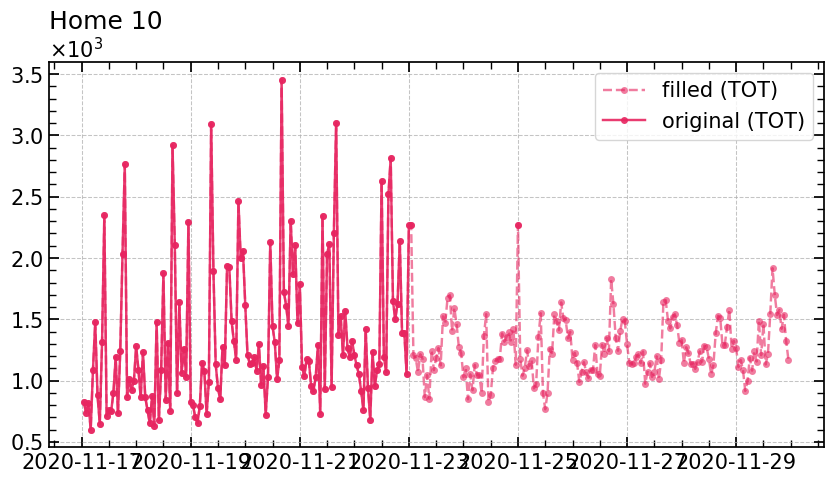

In [10]:
home_to_plot = 10
fig,  ax =  plt.subplots( figsize = (10,5))
#focus on may 2019
query = 'index > "2020-11-17" and index < "2020-11-30"'
ax.plot(energy_filled.query(query).index, energy_filled.query(query)[f'P_TOT_{home_to_plot}'], 'C1o--', alpha=0.6, label = 'filled (TOT)')
ax.plot(energy.query(query).index, energy.query(query)[f'P_TOT_{home_to_plot}'], 'C1o-', alpha=0.9, label = 'original (TOT)')

ax.set_title(f'Home {home_to_plot}')
ax.legend()

# Spectrogram exploration of substation consumption

/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_19501/203133890.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax2.pcolormesh(Sxx_df.index, Sxx_df.columns, np.log10(Sxx_df.T), shading='gouraud', cmap='PiYG')


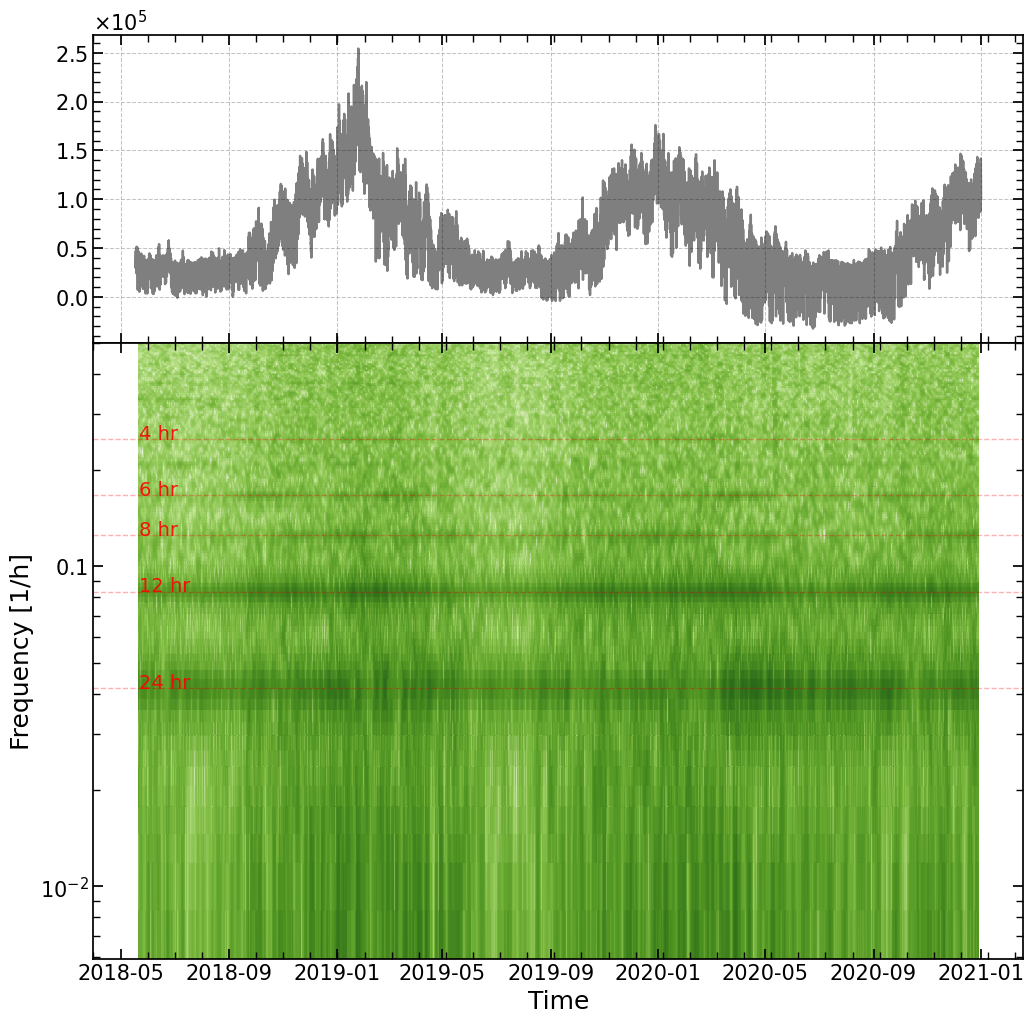

In [11]:
from scipy import signal
ts = energy_filled[['P_substation']].fillna(method='ffill')

spectra = signal.spectrogram(ts.iloc[:, 0], nperseg=24*7, noverlap = 24*7-1, scaling='spectrum', mode='psd', detrend='linear', window = 'tukey')
f, t, Sxx = spectra

Sxx_df = pd.DataFrame(Sxx, index = f, columns = t)
Sxx_df = Sxx_df.T
Sxx_df.index = pd.Series(Sxx_df.index).apply(lambda x: ts.index[int(x)]).values

Sxx_df.drop(columns = 0, inplace = True)


# Sxx_df_rebinned = Sxx_df.T.copy()
# f_bins = np.logspace(np.log10(0.01), np.log10(0.5), 14)
# f_bins_mid = (f_bins[1:] + f_bins[:-1])/2
# Sxx_df_rebinned  = Sxx_df_rebinned.groupby(pd.cut(Sxx_df_rebinned.index, bins = f_bins)).mean()
# Sxx_df_rebinned.index = f_bins_mid
# Sxx_df_rebinned = Sxx_df_rebinned.T


#%matplotlib auto
#%matplotlib inline

fig, [ax1, ax2] =  plt.subplots(nrows=2, ncols = 1, sharex = True, gridspec_kw = {'hspace':0, 'height_ratios': [1,2]}, figsize = (12,12))


ax2.pcolormesh(Sxx_df.index, Sxx_df.columns, np.log10(Sxx_df.T), shading='gouraud', cmap='PiYG')

for period_hr in [24, 12, 8, 4, 6]:
    ax2.axhline(1/period_hr, color='r', linestyle='--', lw=1, alpha = 0.3, label = f'{period_hr} hr')
    ax2.text(Sxx_df.index[0], 1/period_hr, f'{period_hr} hr', color='r', fontsize=14, alpha = 0.9)
ax2.set_yscale('log')

ax1.plot(ts.index, ts.iloc[:, 0], 'k-', alpha=0.5, label = 'original')

plt.ylabel('Frequency [1/h]')
plt.xlabel('Time')
plt.show()



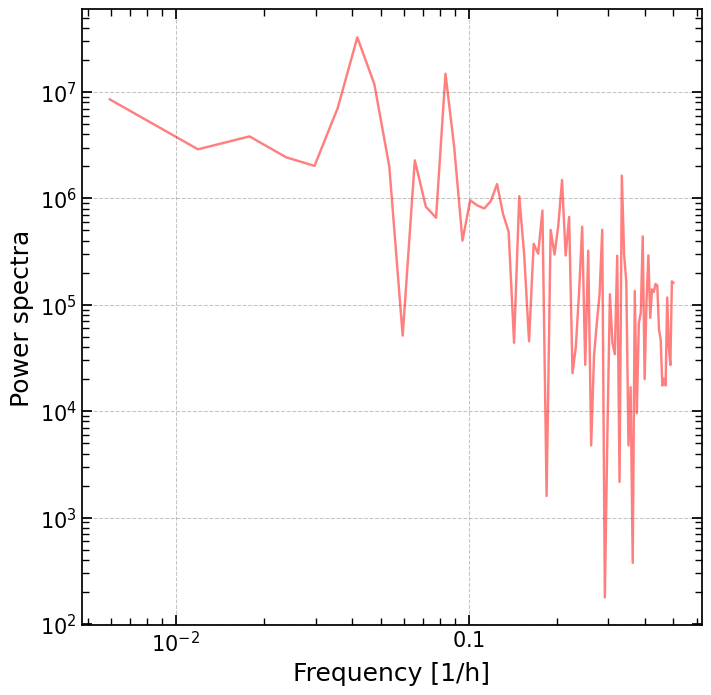

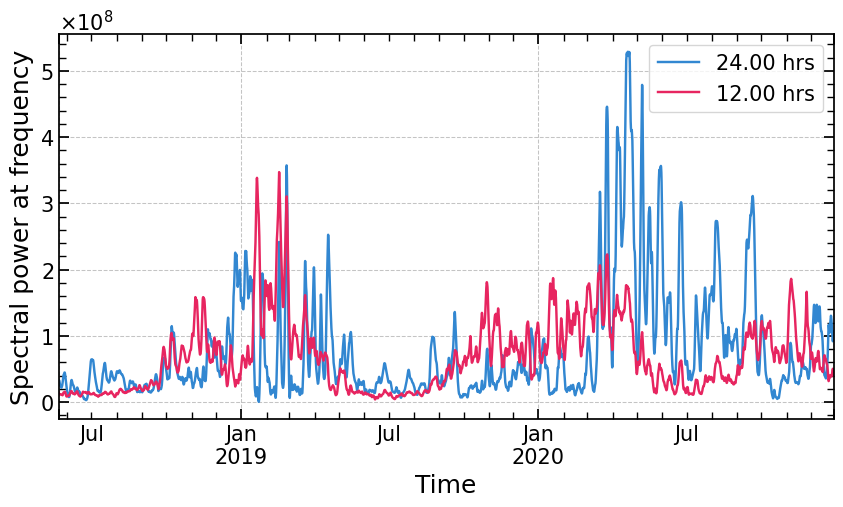

In [12]:
%matplotlib inline

fig,  ax =  plt.subplots( figsize = (8,8))
ax.loglog(Sxx_df.iloc[0].index, Sxx_df.iloc[0].values, 'r-', alpha=0.5, label = 'original')
ax.set(xlabel='Frequency [1/h]', ylabel='Power spectra')

fig,  ax =  plt.subplots( figsize = (10,5))
Sxx_df.iloc[:, [6, 13] ].plot(ax=ax )
ax.set(xlabel='Time', ylabel='Spectral power at frequency')
freqs = Sxx_df.columns[[6, 13]].values
ax.legend([f'{1/freqs[0]:.2f} hrs', f'{1/freqs[1]:.2f} hrs'])

# Random forest forecast  attempt

In [13]:
data = energy_filled[['P_substation', 'hour','weekday','month','year','doy','season','workday']].fillna(method='ffill')

Sxx_df_tmp = Sxx_df.copy()
Sxx_df_tmp.columns = [f'f_{i}' for i,x in enumerate(Sxx_df.columns, 1)]
Sxx_df_tmp = Sxx_df_tmp[['f_5', 'f_12']]
data = data.merge(Sxx_df_tmp, left_index=True, right_index=True)

#features_cols are all the columns that are not time related

features_cols = ['P_substation'] + [x for x in Sxx_df_tmp.columns]

max_lag = 5

lags_cols = []

for lag in range(1, max_lag+1):
    for col in features_cols:
        tmp = data[col].shift(lag)
        tmp.name = f'{col}_lag_{lag}'
        lags_cols.append(tmp)

data = data.merge(pd.concat(lags_cols, axis=1), left_index=True, right_index=True)

data = data.dropna()

freq_cols = [x for x in data.columns if 'f_' in x]


data = data.drop(columns = ['year', 'doy',	'season',])
#data = data.drop(columns = freq_cols)

data['workday'] = data['workday'].apply(lambda x: 1 if x=='workday' else 0)





data.head(10)

,P_substation,hour,weekday,month,workday,f_5,f_12,P_substation_lag_1,f_5_lag_1,f_12_lag_1,P_substation_lag_2,f_5_lag_2,f_12_lag_2,P_substation_lag_3,f_5_lag_3,f_12_lag_3,P_substation_lag_4,f_5_lag_4,f_12_lag_4,P_substation_lag_5,f_5_lag_5,f_12_lag_5
2018-05-21 18:00:00,46284.093625,18,0,5,1,1.573868e+06,918901.106622,40000.373003,1.692172e+06,919301.836439,38490.146164,1.800780e+06,910531.321046,23161.054951,1.893266e+06,893157.330973,21798.228559,1.966345e+06,867865.615542,13125.486475,2.023340e+06,835286.285766
2018-05-21 19:00:00,42921.281261,19,0,5,1,1.460080e+06,910134.115345,46284.093625,1.573868e+06,918901.106622,40000.373003,1.692172e+06,919301.836439,38490.146164,1.800780e+06,910531.321046,23161.054951,1.893266e+06,893157.330973,21798.228559,1.966345e+06,867865.615542
2018-05-21 20:00:00,42032.049655,20,0,5,1,1.342467e+06,895558.014799,42921.281261,1.460080e+06,910134.115345,46284.093625,1.573868e+06,918901.106622,40000.373003,1.692172e+06,919301.836439,38490.146164,1.800780e+06,910531.321046,23161.054951,1.893266e+06,893157.330973
2018-05-21 21:00:00,30850.953445,21,0,5,1,1.227419e+06,877963.573604,42032.049655,1.342467e+06,895558.014799,42921.281261,1.460080e+06,910134.115345,46284.093625,1.573868e+06,918901.106622,40000.373003,1.692172e+06,919301.836439,38490.146164,1.800780e+06,910531.321046
2018-05-21 22:00:00,27904.321197,22,0,5,1,1.110881e+06,858381.876619,30850.953445,1.227419e+06,877963.573604,42032.049655,1.342467e+06,895558.014799,42921.281261,1.460080e+06,910134.115345,46284.093625,1.573868e+06,918901.106622,40000.373003,1.692172e+06,919301.836439
2018-05-21 23:00:00,29074.464893,23,0,5,1,9.894567e+05,836919.911856,27904.321197,1.110881e+06,858381.876619,30850.953445,1.227419e+06,877963.573604,42032.049655,1.342467e+06,895558.014799,42921.281261,1.460080e+06,910134.115345,46284.093625,1.573868e+06,918901.106622
2018-05-22 00:00:00,28081.179433,0,1,5,1,8.659848e+05,812869.203542,29074.464893,9.894567e+05,836919.911856,27904.321197,1.110881e+06,858381.876619,30850.953445,1.227419e+06,877963.573604,42032.049655,1.342467e+06,895558.014799,42921.281261,1.460080e+06,910134.115345
2018-05-22 01:00:00,28351.200784,1,1,5,1,7.435675e+05,787244.212318,28081.179433,8.659848e+05,812869.203542,29074.464893,9.894567e+05,836919.911856,27904.321197,1.110881e+06,858381.876619,30850.953445,1.227419e+06,877963.573604,42032.049655,1.342467e+06,895558.014799
2018-05-22 02:00:00,31182.352314,2,1,5,1,6.252655e+05,760033.514832,28351.200784,7.435675e+05,787244.212318,28081.179433,8.659848e+05,812869.203542,29074.464893,9.894567e+05,836919.911856,27904.321197,1.110881e+06,858381.876619,30850.953445,1.227419e+06,877963.573604
2018-05-22 03:00:00,24702.659169,3,1,5,1,5.139683e+05,732239.882844,31182.352314,6.252655e+05,760033.514832,28351.200784,7.435675e+05,787244.212318,28081.179433,8.659848e+05,812869.203542,29074.464893,9.894567e+05,836919.911856,27904.321197,1.110881e+06,858381.876619


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from typing import Tuple

def mape(y_true: np.ndarray, y_pred: np.ndarray)->np.ndarray:
    """
    Calculates the mean absolute percentage error.
    Args:
        y_true (np.ndarray): True values.
        y_pred (np.ndarray): Predicted values.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true))*100



def model_fit(data: pd.DataFrame, model: RandomForestRegressor , target_col: str = 'P_substation', test_size: float = 0.3, visualize: bool = True, diff_frac: float = 0.4)->Tuple[RandomForestRegressor, pd.DateOffset]:
    """
    Fits the model and calculates the MAPE.
    Args:
        data (pd.DataFrame): Dataframe with the target variable.
        model (RandomForestRegressor): Model to fit.
        target_col (str): Name of the target variable.
        test_size (float): Size of the test set.
        visualize (bool): Whether to visualize the results.
        diff_frac (float): Fraction of the data to use as a definition of outliers (for plotting)
    """





    train, test = train_test_split(
            data, shuffle=False, test_size=test_size )

    X_train = train.drop(target_col, axis=1)
    y_train = train[target_col]

    X_test = test.drop(target_col, axis=1)
    y_test = test[target_col]

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_score = mape(y_train, y_train_pred)
    test_score = mape(y_test, y_test_pred)

    print('Train MAPE: {}'.format(train_score))
    print('Test MAPE: {}'.format(test_score))



    train['pred'] = y_train_pred
    train['train'] = True
    test['pred'] = y_test_pred
    test['train'] = False


    df_res = pd.concat([train, test], axis=0)

    df_res['relative_error'] = (df_res['P_substation'] - df_res['pred']) / df_res['pred']

    if visualize:
        plt.figure(figsize=(9, 9))
        plt.plot(df_res.query('train')['P_substation'], df_res.query('train')['pred'], 'o', label='train', alpha = 0.5, color = 'C1')
        plt.plot(df_res.query('not train')['P_substation'], df_res.query('not train')['pred'], 'o', label='test', alpha = 0.5, color = 'C2')

        max_mw, min_mw = df_res['P_substation'].max(), df_res['P_substation'].min()
        ideal_line = np.linspace(min_mw, max_mw, 100)
        ideal_line_14 = ideal_line * (diff_frac + 1)
        ideal_line_06 = ideal_line * (1 - diff_frac)

        plt.plot(ideal_line, ideal_line, 'k:', alpha = 0.5, label = f'ideal +- {diff_frac*100}%')
        plt.plot(ideal_line, ideal_line_14, 'k--', alpha = 0.2)
        plt.plot(ideal_line, ideal_line_06, 'k--', alpha = 0.2)

        plt.xlabel('actual consumption')
        plt.ylabel('predicted consumption')
        plt.xlim(min_mw, max_mw)
        plt.ylim(min_mw, max_mw)
        
        plt.legend()
        plt.show()


        plt.figure(figsize=(10, 5))
        plt.plot(df_res.query('train')['P_substation'], label='train', alpha = 0.5, color = 'C1')
        plt.plot(df_res.query('train')['pred'], label='train pred', alpha = 0.5, color = 'C1', linestyle = '--')

        plt.plot(df_res.query('not train')['P_substation'], label='test', alpha = 0.5, color = 'C2')
        plt.plot(df_res.query('not train')['pred'], label='test pred', alpha = 0.5, color = 'C2', linestyle = '--')

        plt.xlabel('time')
        plt.ylabel('consumption')
        plt.legend()
        plt.title('Actual and predicted values')
        plt.xticks(rotation=45)
        plt.show()


        #plot last week of train
        plt.figure(figsize=(10, 5))
        plt.plot(df_res.query('train').tail(7*24)['P_substation'], label='train', alpha = 0.5, color = 'C1')
        plt.plot(df_res.query('train').tail(7*24)['pred'], label='train pred', alpha = 0.5, color = 'C0', linestyle = '--')

        plt.xlabel('time')
        plt.ylabel('consumption')
        plt.legend()
        plt.title('Last week of train')
        plt.xticks(rotation=45)


        #plot last week of test
        plt.figure(figsize=(10, 5))
        plt.plot(df_res.query('not train').tail(7*24)['P_substation'], label='test', alpha = 0.5, color = 'C2')
        plt.plot(df_res.query('not train').tail(7*24)['pred'], label='test pred', alpha = 0.5, color = 'C3', linestyle = '--')

        plt.xlabel('time')
        plt.ylabel('consumption')
        plt.legend()
        plt.title('Last week of test')
        plt.xticks(rotation=45)


        plt.show()



    return model, df_res


default_model = RandomForestRegressor(n_estimators=700, max_depth=6, n_jobs=-1,bootstrap = False)

Train MAPE: 18.280372016013473
Test MAPE: 83.87295765518708


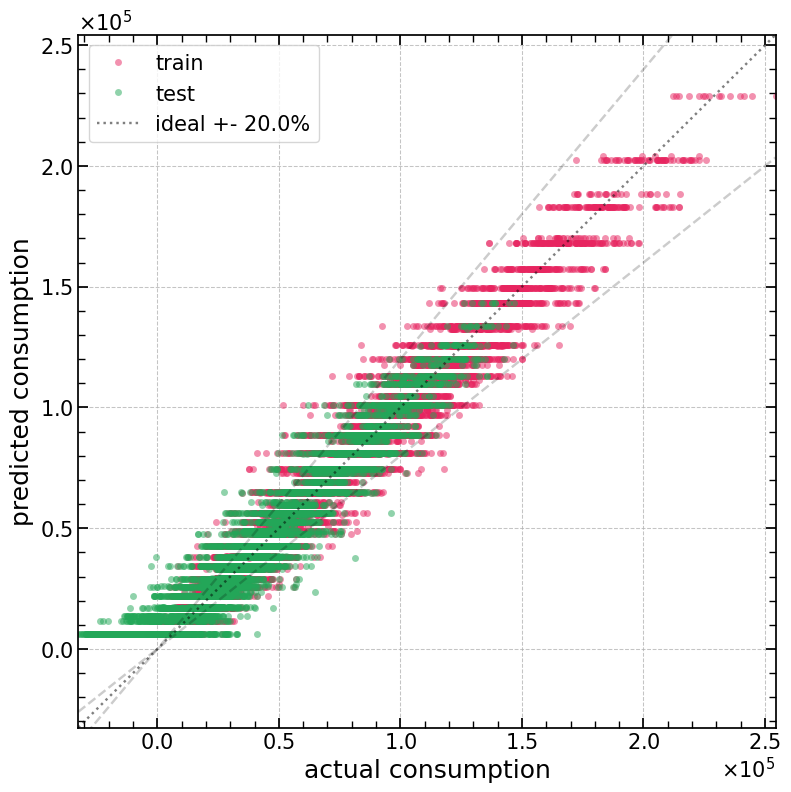

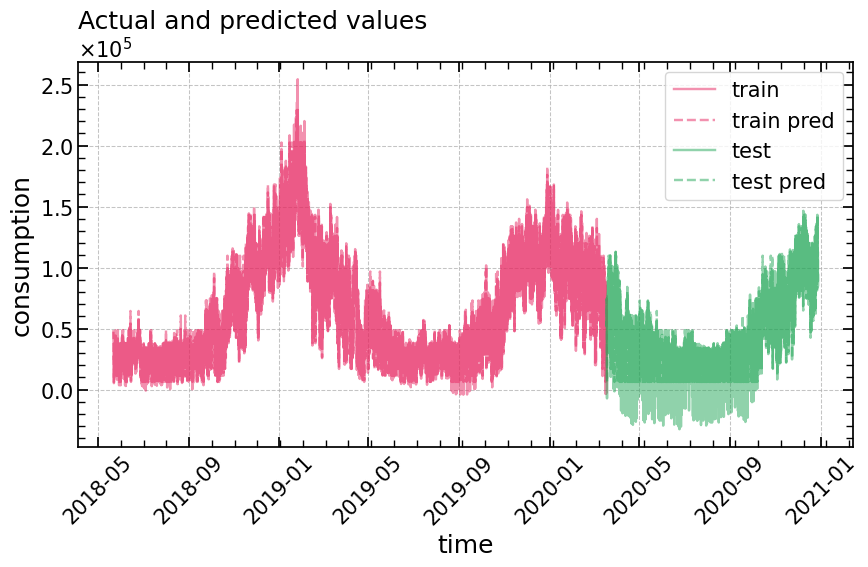

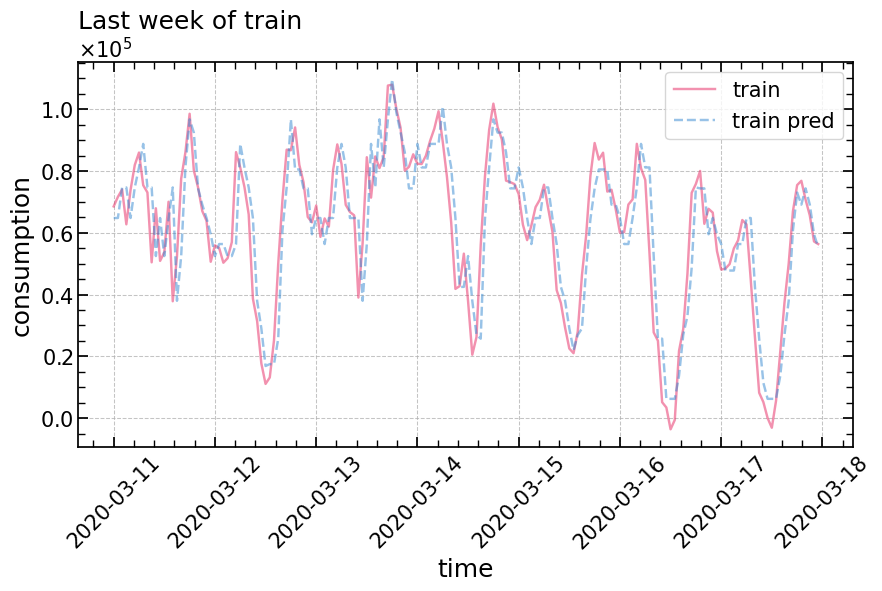

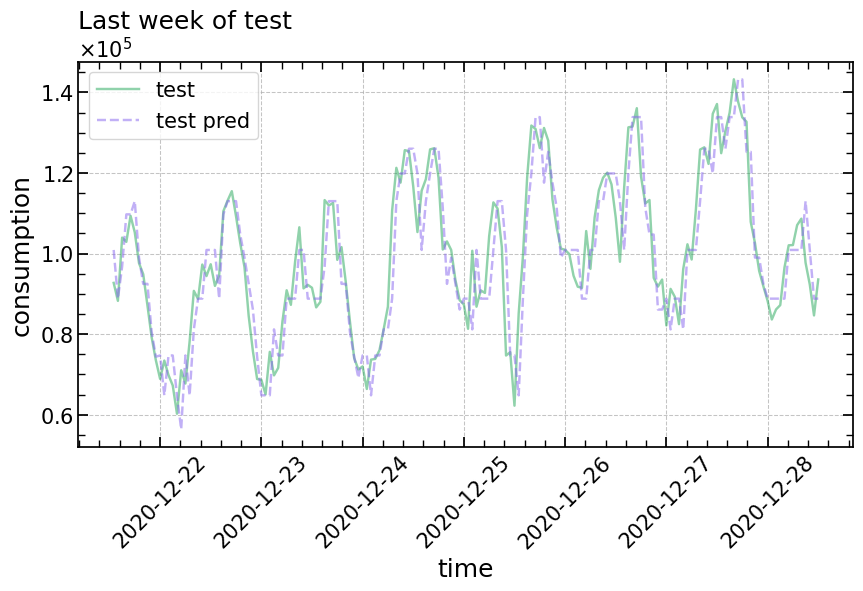

In [15]:
model, df_fit = model_fit(data, default_model,  test_size=0.3, visualize=True, diff_frac = 0.2)